In [1]:
# ── Standard library ───────────────────────────────────────────
import re
import ast
from math import ceil
from typing import List, Tuple
from copy import deepcopy

# ── Third-party ────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ── ASE ────────────────────────────────────────────────────────
import ase
from ase import Atom, Atoms
from ase.geometry import cell_to_cellpar      
from ase.build import surface
from ase.visualize import view
from ase.calculators.emt import EMT            
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE, LBFGS
from ase.mep import NEB
from ase import Atoms, units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md import VelocityVerlet

# ── Pymatgen ───────────────────────────────────────────────────
from pymatgen.core.structure import Structure, Lattice
from pymatgen.core.composition import Composition
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

# ChemDX Data Preprocessing

In [2]:
def is_binary_balanced(formula):
    try:
        comp = Composition(str(formula))
        if len(comp) != 2:
            return False
        amounts = list(comp.get_el_amt_dict().values())
        return amounts[0] == amounts[1]
    except:
        return False

# EMT potential list
EMT_list = {"Al", "Cu", "Ag", "Au", "Ni", "Pd", "Pt"}
def contains_only_target(formula):
    elements = re.findall(r"[A-Z][a-z]?", str(formula))
    return set(elements).issubset(EMT_list)

def is_orthogonal(atoms, tol=1e-2):
    # Extract a, b, c, alpha, beta, gamma
    _, _, _, alpha, beta, gamma = cell_to_cellpar(atoms.cell)
    # Check if angles are approximately 90 degrees within tolerance
    return all(abs(angle - 90.0) < tol for angle in [alpha, beta, gamma])

In [3]:
ChemDX_data=pd.read_csv('MatDX_EF.csv', encoding='utf-8-sig')

filtered_ChemDX_data = ChemDX_data[ChemDX_data["formula"].apply(contains_only_target)].reset_index(drop=True)
mask = filtered_ChemDX_data['formula'].map(is_binary_balanced)
balanced_binary_data = filtered_ChemDX_data[mask].reset_index(drop=True)

ase_list = []
for i in range(len(balanced_binary_data['structure'].to_list())):
    try:
        struct_list = ast.literal_eval(balanced_binary_data.loc[i, 'structure'])
        d = struct_list[0]['data']
        cell = np.array([d['a'], d['b'], d['c']], dtype=float) * 1e10 # Convert from meters to Angstroms
        positions = np.array([[a['x'], a['y'], a['z']] for a in d['atoms']], dtype=float) * 1e10 
        symbols = [a['element'] for a in d['atoms']]
        ase_list.append(Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True))
    except:
        continue

# Convert ASE Atoms object to a pymatgen Structure object (for conventional cell conversion)
conv_ase_list = []
for atoms in ase_list:
    pmg_struct = AseAtomsAdaptor.get_structure(atoms)
    sga = SpacegroupAnalyzer(pmg_struct)
    pmg_conv = sga.get_conventional_standard_structure()
    conv_ase_list.append(AseAtomsAdaptor.get_atoms(pmg_conv))

orthogonal_ase_list = [atoms for atoms in conv_ase_list if is_orthogonal(atoms)]

In [4]:
adaptor = AseAtomsAdaptor()

def pmg_supercell_min_ab(
    ase_atoms: Atoms, min_len: float = 15.0, repeat_z: int = 1
) -> Tuple[Atoms, Tuple[int, int, int]]:
    """
    a,b 축이 min_len Å 미만이면 최소 min_len 이상이 되도록 가장 작은 정수배 슈퍼셀을 생성.
    pymatgen에서 슈퍼셀 생성 후 다시 ASE Atoms로 변환.
    반환: (새 ASE Atoms, (nx, ny, nz))
    """
    # ASE -> pymatgen
    struct = adaptor.get_structure(ase_atoms)

    a = struct.lattice.a
    b = struct.lattice.b

    nx = 1 if a >= min_len else ceil(min_len / a)
    ny = 1 if b >= min_len else ceil(min_len / b)
    nz = max(1, int(repeat_z))

    # pymatgen에서 슈퍼셀 생성 (원자 복제 → 확장부가 원자로 채워짐)
    sc_struct = struct * (nx, ny, nz)

    # pymatgen -> ASE
    out_atoms = adaptor.get_atoms(sc_struct)

    # 원래 PBC 플래그 보존 및 좌표 정리
    out_atoms.set_pbc(ase_atoms.get_pbc())
    out_atoms.wrap()
    return out_atoms, (nx, ny, nz)

def pmg_batch_min_ab(
    ase_list: List[Atoms], min_len: float = 15.0, repeat_z: int = 1
) -> List[Atoms]:
    """
    리스트의 각 ASE Atoms에 대해 위 규칙으로 슈퍼셀을 만든 뒤 새 리스트로 반환.
    진행 로그를 출력.
    """
    out_list = []
    for i, at in enumerate(ase_list):
        sc, reps = pmg_supercell_min_ab(at, min_len=min_len, repeat_z=repeat_z)
        a0, b0, c0, alpha0, beta0, gamma0 = at.cell.cellpar()
        a1, b1, c1, alpha1, beta1, gamma1 = sc.cell.cellpar()
        out_list.append(sc)
    return out_list

new_ase_list = pmg_batch_min_ab(orthogonal_ase_list, min_len=15.0, repeat_z=1)
#ase 기반 slab 생성

slab = surface(new_ase_list[2], (0, 0, 1), layers=1, vacuum=8.0)

In [5]:
# Matrix 크기 변환 part -> 하지 않아도 무방함
def reduce_cell_with_matrix_ase_to_ase(slab, 
    P=np.array([[0.6, 0.0, 0.0],
                [0.0, 0.6, 0.0],
                [0.0, 0.0, 1.0]]),
    frac_round=6
):
    """
    ASE Atoms (slab) -> pymatgen Structure에서 셀 변환(L' = L P) 및 f' = f P^{-1} 적용,
    좌표 래핑/중복제거 후 ASE Atoms로 반환.
    """
    # 1) ASE -> pymatgen
    s = AseAtomsAdaptor.get_structure(slab)  # type: Structure
    
    # 2) 새 격자와 새 분수좌표 계산
    L_old = s.lattice.matrix                 # 3x3
    P = np.array(P, dtype=float)
    Pinv = np.linalg.inv(P)

    L_new = L_old @ P                        # L' = L P
    frac_old = s.frac_coords                 # N x 3
    frac_new = frac_old @ Pinv               # f' = f P^{-1}

    # 3) [0,1)로 래핑
    frac_new = np.mod(frac_new, 1.0)

    # 4) 중복(같은 자리) 원자 제거: 분수좌표 라운딩 + (원소, 좌표) key로 유일화
    species = [str(sp) for sp in s.species]
    keys_seen = set()
    keep_idx = []
    for i, (sp, f) in enumerate(zip(species, frac_new)):
        key = (sp, round(float(f[0]), frac_round), 
                    round(float(f[1]), frac_round), 
                    round(float(f[2]), frac_round))
        if key not in keys_seen:
            keys_seen.add(key)
            keep_idx.append(i)

    species_new = [s.species[i] for i in keep_idx]
    frac_new_kept = frac_new[keep_idx, :]
    s_new = Structure(Lattice(L_new), species_new, frac_new_kept, to_unit_cell=True, coords_are_cartesian=False)
    new_atoms = AseAtomsAdaptor.get_atoms(s_new)
    return new_atoms

P = np.array([[0.6, 0.0, 0.0],
              [0.0, 0.6, 0.0],
              [0.0, 0.0, 1.0]])

slab_ = reduce_cell_with_matrix_ase_to_ase(slab, P=P, frac_round=6)

# Slab Relaxation

In [6]:
calc = EMT()
slab_.pbc = [True, True, False]
slab_.calc = EMT()

scaled_positions = slab_.get_scaled_positions()
# z fractional < 0.5 인 원자 고정
mask = [pos[2] < 0.5 for pos in scaled_positions]
# constraint 적용
slab_.set_constraint(FixAtoms(mask=mask))
slab_.calc = calc

# Initial state:
qn = LBFGS(slab_, trajectory='slab_Rlx.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:24:43       18.328798        1.502341
LBFGS:    1 21:24:43       17.873597        1.393816
LBFGS:    2 21:24:43       15.599793        0.199237
LBFGS:    3 21:24:43       15.587307        0.134541
LBFGS:    4 21:24:43       15.582231        0.128256
LBFGS:    5 21:24:43       15.526174        0.032901


np.True_

# Generation and Relaxation of Au Adatom on Slab

In [16]:
# 분수좌표 정의
frac_hollow = [0.338420004, 0.165470004, 0.72000]
frac_bridge = [0.500000000, 0.164765999, 0.72000]
frac_ontop  = [0.507979989, 0.337029994, 0.72000]

def add_adatom(base_slab, frac_pos, symbol="Au"):
    new_slab = deepcopy(base_slab)
    cart_pos = np.dot(frac_pos, base_slab.get_cell())
    # 단일 원자 추가
    new_slab.append(Atom(symbol, position=cart_pos))
    return new_slab

# 각각 생성
Hollow = add_adatom(slab_, frac_hollow)
Bridge = add_adatom(slab_, frac_bridge)
Top  = add_adatom(slab_, frac_ontop)

In [17]:
scaled_positions = Hollow.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Hollow.set_constraint(FixAtoms(mask=mask))
Hollow.calc = EMT()

qn = LBFGS(Hollow, trajectory='Hollow.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:29:51       16.899845        1.651597
LBFGS:    1 21:29:51       16.842147        1.654692
LBFGS:    2 21:29:51       16.381694        1.542211
LBFGS:    3 21:29:51       16.030882        1.065780
LBFGS:    4 21:29:51       15.927303        0.491786
LBFGS:    5 21:29:51       15.912045        0.356586
LBFGS:    6 21:29:51       15.902587        0.362736
LBFGS:    7 21:29:51       15.815509        0.482162
LBFGS:    8 21:29:51       15.808340        0.493908
LBFGS:    9 21:29:51       15.789599        0.372136
LBFGS:   10 21:29:51       15.775211        0.249779
LBFGS:   11 21:29:51       15.760200        0.181759
LBFGS:   12 21:29:51       15.753326        0.122775
LBFGS:   13 21:29:51       15.751473        0.128542
LBFGS:   14 21:29:51       15.746506        0.117581
LBFGS:   15 21:29:51       15.741153        0.107962
LBFGS:   16 21:29:51       15.737032        0.085541
LBFGS:   17 21:29:51       15.735354        0.06

np.True_

In [20]:
view(Hollow, viewer='x3d')

In [18]:
scaled_positions = Top.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Top.set_constraint(FixAtoms(mask=mask))
Top.calc = EMT()
Top.calc = calc 

qn = LBFGS(Top, trajectory='Top.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:29:52       16.993959        1.811865
LBFGS:    1 21:29:52       16.921302        1.047687
LBFGS:    2 21:29:52       16.875674        0.228009
LBFGS:    3 21:29:52       16.872013        0.119640
LBFGS:    4 21:29:52       16.870132        0.115420
LBFGS:    5 21:29:52       16.866438        0.201435
LBFGS:    6 21:29:52       16.861199        0.248151
LBFGS:    7 21:29:52       16.856090        0.242343
LBFGS:    8 21:29:52       16.852786        0.145567
LBFGS:    9 21:29:52       16.851131        0.116678
LBFGS:   10 21:29:52       16.849404        0.199707
LBFGS:   11 21:29:52       16.845087        0.321217
LBFGS:   12 21:29:52       16.837456        0.415810
LBFGS:   13 21:29:52       16.828063        0.386454
LBFGS:   14 21:29:52       16.822446        0.233712
LBFGS:   15 21:29:52       16.818401        0.172906
LBFGS:   16 21:29:52       16.814410        0.279486
LBFGS:   17 21:29:52       16.807993        0.37

np.True_

In [21]:
view(Top, viewer='x3d')

In [19]:
scaled_positions = Bridge.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Bridge.set_constraint(FixAtoms(mask=mask))
Bridge.calc = EMT()
qn = LBFGS(Bridge, trajectory='Bridge.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:29:52       16.680418        1.339263
LBFGS:    1 21:29:52       16.637963        1.270728
LBFGS:    2 21:29:52       16.448248        0.488844
LBFGS:    3 21:29:52       16.437177        0.312964
LBFGS:    4 21:29:52       16.433528        0.169745
LBFGS:    5 21:29:52       16.431419        0.201674
LBFGS:    6 21:29:52       16.425710        0.248900
LBFGS:    7 21:29:52       16.417049        0.275862
LBFGS:    8 21:29:52       16.409510        0.227475
LBFGS:    9 21:29:52       16.406284        0.135560
LBFGS:   10 21:29:52       16.403687        0.130036
LBFGS:   11 21:29:52       16.399925        0.175813
LBFGS:   12 21:29:52       16.392400        0.261049
LBFGS:   13 21:29:52       16.379938        0.315258
LBFGS:   14 21:29:52       16.365337        0.427866
LBFGS:   15 21:29:52       16.347315        0.363776
LBFGS:   16 21:29:52       16.302638        0.392704
LBFGS:   17 21:29:52       16.263476        0.41

np.True_

In [22]:
view(Bridge, viewer='x3d')

# Generation and relaxation of NEB
# Dataset1: Hollow -> Bridge -> Hollow
# Dataset2: Hollow -> Ontop -> Hollow

In [25]:
frac_initial = [0.333333343, 0.165470004, 0.720000029]
frac_final1  = [0.666665971, 0.165470004, 0.720000029]
frac_final2  = [0.671999991, 0.500000000, 0.720000029]

# 각각 생성
Initial_1 = add_adatom(slab_, frac_initial)
Final_1  = add_adatom(slab_, frac_final1)
Final_2  = add_adatom(slab_, frac_final2)

In [26]:
scaled_positions = Initial_1.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Initial_1.set_constraint(FixAtoms(mask=mask))
Initial_1.calc = EMT()
Initial_1.calc = calc
qn = LBFGS(Initial_1)
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:36:41       16.900482        1.651694
LBFGS:    1 21:36:41       16.842805        1.654928
LBFGS:    2 21:36:41       16.382168        1.545237
LBFGS:    3 21:36:41       16.029430        1.075987
LBFGS:    4 21:36:41       15.920139        0.380964
LBFGS:    5 21:36:41       15.906858        0.322125
LBFGS:    6 21:36:41       15.897784        0.338983
LBFGS:    7 21:36:41       15.818001        0.482170
LBFGS:    8 21:36:41       15.806875        0.546775
LBFGS:    9 21:36:41       15.792911        0.502305
LBFGS:   10 21:36:41       15.780825        0.362140
LBFGS:   11 21:36:41       15.765901        0.197666
LBFGS:   12 21:36:41       15.754079        0.132362
LBFGS:   13 21:36:41       15.751020        0.110134
LBFGS:   14 21:36:41       15.749185        0.114977
LBFGS:   15 21:36:41       15.743782        0.109957
LBFGS:   16 21:36:41       15.738967        0.100911
LBFGS:   17 21:36:41       15.735791        0.07

np.True_

In [27]:
scaled_positions = Final_1.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Final_1.set_constraint(FixAtoms(mask=mask))
Final_1.calc = EMT()
Final_1.calc = calc
qn = LBFGS(Final_1)
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:36:41       16.900482        1.651694
LBFGS:    1 21:36:41       16.842805        1.654928
LBFGS:    2 21:36:41       16.382168        1.545237
LBFGS:    3 21:36:41       16.029430        1.075987
LBFGS:    4 21:36:41       15.920139        0.380977
LBFGS:    5 21:36:41       15.906858        0.322125
LBFGS:    6 21:36:41       15.897784        0.338983
LBFGS:    7 21:36:41       15.818001        0.482170
LBFGS:    8 21:36:41       15.806875        0.546775
LBFGS:    9 21:36:41       15.792911        0.502305
LBFGS:   10 21:36:41       15.780825        0.362140
LBFGS:   11 21:36:41       15.765901        0.197666
LBFGS:   12 21:36:41       15.754079        0.132362
LBFGS:   13 21:36:41       15.751020        0.110134
LBFGS:   14 21:36:41       15.749185        0.114977
LBFGS:   15 21:36:41       15.743782        0.109957
LBFGS:   16 21:36:41       15.738967        0.100911
LBFGS:   17 21:36:41       15.735791        0.07

np.True_

In [28]:
scaled_positions = Final_2.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Final_2.set_constraint(FixAtoms(mask=mask))
Final_2.calc = EMT()
Final_2.calc = calc
qn = LBFGS(Final_2)
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 21:36:42       16.899818        1.651593
LBFGS:    1 21:36:42       16.842119        1.654682
LBFGS:    2 21:36:42       16.381674        1.542083
LBFGS:    3 21:36:42       16.030943        1.065341
LBFGS:    4 21:36:42       15.927607        0.469212
LBFGS:    5 21:36:42       15.912265        0.357804
LBFGS:    6 21:36:42       15.902796        0.363614
LBFGS:    7 21:36:42       15.815410        0.482856
LBFGS:    8 21:36:42       15.808368        0.492039
LBFGS:    9 21:36:42       15.788979        0.361255
LBFGS:   10 21:36:42       15.774641        0.238322
LBFGS:   11 21:36:42       15.759687        0.175198
LBFGS:   12 21:36:42       15.753303        0.123821
LBFGS:   13 21:36:42       15.751445        0.129121
LBFGS:   14 21:36:42       15.746229        0.116494
LBFGS:   15 21:36:42       15.740875        0.106325
LBFGS:   16 21:36:42       15.736886        0.077668
LBFGS:   17 21:36:42       15.735316        0.06

np.True_

In [29]:
initial_copy = Initial_1.copy()
final_copy = Final_1.copy()
fix = FixAtoms(mask=mask)

for im in (initial_copy, final_copy):
    im.calc = EMT()
    im.set_constraint(fix)

images = []
for i in range(10):
    image = initial_copy.copy()
    image.calc = EMT()
    image.set_constraint(FixAtoms(mask=mask))
    images.append(image)

images.append(final_copy)
neb = NEB(images)
neb.interpolate(method='idpp')

qn = LBFGS(neb, trajectory='NEB_training_1.traj')
qn.run(fmax=0.05)


# Save images to xyz trajectory for future visualization
images = ase.io.read('NEB_training_1.traj', ':')
ase.io.write('NEB_training_1.extxyz', images)

       Step     Time          Energy          fmax
LBFGS:    0 21:38:33       17.225137        3.838791
LBFGS:    1 21:38:33       16.799634        2.444428
LBFGS:    2 21:38:33       16.453922        0.579590
LBFGS:    3 21:38:33       16.422346        0.415559
LBFGS:    4 21:38:33       16.406398        0.416293
LBFGS:    5 21:38:33       16.382851        0.469267
LBFGS:    6 21:38:33       16.351089        0.508512
LBFGS:    7 21:38:33       16.327706        0.522195
LBFGS:    8 21:38:33       16.315159        0.417075
LBFGS:    9 21:38:34       16.309907        0.460135
LBFGS:   10 21:38:34       16.295196        0.614626
LBFGS:   11 21:38:34       16.240077        0.696661
LBFGS:   12 21:38:34       16.171504        0.682536
LBFGS:   13 21:38:34       16.149464        0.547597
LBFGS:   14 21:38:34       16.148150        0.559491
LBFGS:   15 21:38:34       16.137074        0.654604
LBFGS:   16 21:38:34       16.106493        0.666942
LBFGS:   17 21:38:34       16.058918        0.54

In [30]:
initial_copy = Initial_1.copy()
final_copy = Final_2.copy()
for im in (initial_copy, final_copy):
    im.calc = EMT()
    im.set_constraint(fix)

images = []
for i in range(10):
    image = initial_copy.copy()
    image.calc = EMT()
    image.set_constraint(FixAtoms(mask=mask))
    images.append(image)

images.append(final_copy)
neb = NEB(images)
neb.interpolate(method='idpp')

qn = LBFGS(neb, trajectory='NEB_training_2.traj')
qn.run(fmax=0.05)

images = ase.io.read('NEB_training_2.traj', ':')
ase.io.write('NEB_training_2.extxyz', images)

       Step     Time          Energy          fmax
LBFGS:    0 21:38:36       17.156945        2.332690
LBFGS:    1 21:38:36       17.082332        1.407730
LBFGS:    2 21:38:36       16.962227        0.856930
LBFGS:    3 21:38:36       16.911211        0.828811
LBFGS:    4 21:38:36       16.860041        0.824545
LBFGS:    5 21:38:36       16.821777        0.665858
LBFGS:    6 21:38:36       16.796180        0.585788
LBFGS:    7 21:38:36       16.787121        0.615580
LBFGS:    8 21:38:36       16.782092        0.494309
LBFGS:    9 21:38:36       16.769458        0.526301
LBFGS:   10 21:38:36       16.744176        0.700441
LBFGS:   11 21:38:36       16.733001        0.633562
LBFGS:   12 21:38:36       16.734429        0.469061
LBFGS:   13 21:38:36       16.733489        0.478010
LBFGS:   14 21:38:36       16.725357        0.441109
LBFGS:   15 21:38:36       16.714270        0.366652
LBFGS:   16 21:38:36       16.709762        0.389109
LBFGS:   17 21:38:36       16.709571        0.52

# MD simulation

In [31]:
# The ontop site is the most unstable configuration and is therefore used for the MD dataset

Top_for_MD = add_adatom(slab_, frac_ontop)
scaled_positions = Top_for_MD.get_scaled_positions()
mask = [pos[2] < 0.5 for pos in scaled_positions]
Top_for_MD.set_constraint(FixAtoms(mask=mask))

In [32]:
def generate_data(count, filename='training.traj'):
    """Generates test or training data with a simple MD simulation."""
    
    # Trajectory file
    traj = ase.io.Trajectory(filename, 'w')

    # Write MD trajectories around initial image
    initial_copy = Top_for_MD
    initial_copy.calc = EMT()
    initial_copy.get_potential_energy()
    traj.write(initial_copy)
    
    MaxwellBoltzmannDistribution(initial_copy, 300. * units.kB)
    dyn = VelocityVerlet(initial_copy, timestep=1. * units.fs)
    for step in range(count - 1):
        dyn.run(50)
        print(f"Running MD to generate training data — Step {step + 1} completed.")
        traj.write(initial_copy)

In [33]:
# 500 MD perutrbation around initial and final -> total 1000 data
generate_data(count=1000, filename='MD_training.traj')

C:\Users\kasee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ase\md\md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Running MD to generate training data — Step 1 completed.
Running MD to generate training data — Step 2 completed.
Running MD to generate training data — Step 3 completed.
Running MD to generate training data — Step 4 completed.
Running MD to generate training data — Step 5 completed.
Running MD to generate training data — Step 6 completed.
Running MD to generate training data — Step 7 completed.
Running MD to generate training data — Step 8 completed.
Running MD to generate training data — Step 9 completed.
Running MD to generate training data — Step 10 completed.
Running MD to generate training data — Step 11 completed.
Running MD to generate training data — Step 12 completed.
Running MD to generate training data — Step 13 completed.
Running MD to generate training data — Step 14 completed.
Running MD to generate training data — Step 15 completed.
Running MD to generate training data — Step 16 completed.
Running MD to generate training data — Step 17 completed.
Running MD to generate 

In [34]:
# Save images to xyz trajectory for future visualization
images = ase.io.read('MD_training.traj', ':')
ase.io.write('MD_training.extxyz', images)

# Training data generation

In [2]:
images_top= ase.io.read('Top.traj', ':')
print(f"Top frames: {len(images_top)}")

images_hollow = ase.io.read('Hollow.traj', ':')
print(f"Hollow frames: {len(images_hollow)}")

images_bridge = ase.io.read('Bridge.traj', ':')
print(f"Bridge frames: {len(images_bridge)}")

images_md = ase.io.read('MD_training.traj', ':')
print(f"MD frames: {len(images_md)}")

images_neb_1 = ase.io.read('NEB_training_1.traj', ':')
print(f"NEB_1 frames: {len(images_neb_1)}")

images_neb_2 = ase.io.read('NEB_training_2.traj', ':')
print(f"NEB_2 frames: {len(images_neb_2)}")


Top frames: 74
Hollow frames: 55
Bridge frames: 54
MD frames: 1000
NEB_1 frames: 693
NEB_2 frames: 3190


In [ ]:
# training data: MD only
images_all = images_top + images_hollow + images_bridge + images_md
print(f"Training 1 frames: {len(images_all)}")

ase.io.write('training_set_1.traj', images_all)
ase.io.write('training_set_1.extxyz', images_all)

Training 1 frames: 1183


In [ ]:
# training data: MD + NEB
images_neb_1_selected_ = []
for i in range(len(images_neb_1)):
    try:
        images_neb_1[i].get_potential_energy()
        images_neb_1_selected_.append(images_neb_1[i])
    except:
        continue

images_neb_1_selected_= images_neb_1_selected_[-200:]

images_neb_2_selected_ = []
for i in range(len(images_neb_2)):
    try:
        images_neb_2[i].get_potential_energy()
        images_neb_2_selected_.append(images_neb_2[i])
    except:
        continue

# The hollow–ontop–hollow path was extracted by using the early-stage structures,
# since the NEB calculation actually followed a hollow → bridge → hollow → bridge → hollow path.

images_neb_2_selected_ = images_neb_2_selected_[:200]


In [18]:
idx = list(range(len(images_md)))
np.random.shuffle(idx)

images_md_selected = [images_md[i] for i in idx[:len(images_md) - len(images_neb_1_selected_+ images_neb_2_selected_)]]
images_all_2 = images_top + images_hollow + images_bridge + images_md_selected + images_neb_1_selected_ + images_neb_2_selected_

print(f"Training 2 frames: {len(images_all_2)}")

ase.io.write('training_set_2.traj', images_all_2)
ase.io.write('training_set_2.extxyz', images_all_2)

Training 2 frames: 1183


# PES plot 생성

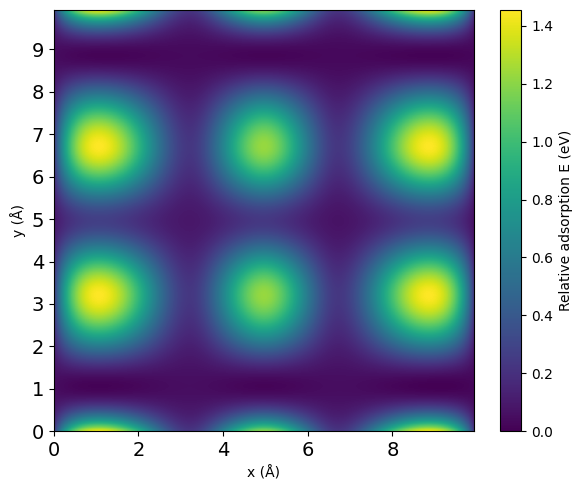

In [ ]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from ase import Atom
from ase.io import read
from ase.calculators.emt import EMT
from ase.optimize import LBFGS
from ase.constraints import FixAtoms, FixedLine
from scipy.interpolate import RegularGridInterpolator

# --- 입력
nx, ny = 7, 7                       # x, y 격자 해상도
fx_range = (0.0, 0.99)               # fractional x 범위
fy_range = (0.0, 0.99)               # fractional y 범위
z_clearance = 1                     # 슬랩 최상단보다 얼마나 위에서 시작할지 [Å]
fmax = 0.05                           # 수렴 기준
max_steps = 500                       # 최적화 최대 스텝

# --- 슬랩 읽기 & 기본 설정
slab = slab_.copy()  # 앞서 준비한 slab_.traj 파일 사용
slab.pbc = [True, True, False]

# 계산기
slab.calc = EMT()

# 하부층 고정 (예: z 분율 < 0.5)
scaled = slab.get_scaled_positions()
bottom_mask = [pos[2] < 0.5 for pos in scaled]
bottom_fix = FixAtoms(mask=bottom_mask)
slab.set_constraint(bottom_fix)

# 슬랩 최상단 z 찾기
z_top = slab.get_positions()[:, 2].max()

# --- 격자 만들기
fx_vals = np.linspace(*fx_range, nx)
fy_vals = np.linspace(*fy_range, ny)
FX, FY = np.meshgrid(fx_vals, fy_vals, indexing='xy')
E = np.zeros((ny, nx))  # PES 에너지 맵

# --- 유틸: 분율좌표 -> 카티지안
def frac_to_cart(frac, cell):
    # frac: (fx, fy, fz)
    return np.dot(frac, cell)  # ASE는 row-vector * cell 으로 처리 가능

# --- 격자 루프
for j, fy in enumerate(fy_vals):
    for i, fx in enumerate(fx_vals):

        # 작업용 카피
        atoms = slab.copy()

        # Au 초기 위치 (x,y는 분율좌표, z는 절대좌표에서 z_top + z_clearance)
        pos0 = frac_to_cart([fx, fy, 0.5], atoms.cell)
        pos0[2] = z_top + z_clearance

        au_index = len(atoms)  # 새 원자의 인덱스가 될 위치
        atoms.append(Atom('Au', position=pos0))

        # 제약: Au는 z-축으로만 이동 (x,y 고정)
        au_z_only = FixedLine(au_index, [0.0, 0.0, 1.0])

        # 기존 하부 고정 + Au z-only를 동시에 적용
        # (원래 있던 FixAtoms는 copy 시 포함되지만, 안전하게 재설정)
        atoms.set_constraint([bottom_fix, au_z_only])
        atoms.calc = EMT()
        opt = LBFGS(atoms, logfile=None)
        opt.run(fmax=fmax, steps=max_steps)
        E[j, i] = atoms.get_potential_energy()

E -= E.min()
upsample = 300  # Sampling 배수                     
nx_hr = (len(fx_vals)-1)*upsample + 1
ny_hr = (len(fy_vals)-1)*upsample + 1

fxi = np.linspace(fx_vals.min(), fx_vals.max(), nx_hr)
fyi = np.linspace(fy_vals.min(), fy_vals.max(), ny_hr)
FXi, FYi = np.meshgrid(fxi, fyi, indexing='xy')

# 보간
interp = RegularGridInterpolator(
    (fy_vals, fx_vals), E,
    method='cubic',          
    bounds_error=False,
    fill_value=np.nan
)

Ei = interp(
    np.column_stack([FYi.ravel(), FXi.ravel()])
).reshape(FYi.shape)
Ei -= np.nanmin(Ei)

# 실길이 좌표 변환
a_len = np.linalg.norm(slab.cell[0])
b_len = np.linalg.norm(slab.cell[1])

Xi = FXi * a_len   # a 방향 실길이(Å)
Yi = FYi * b_len   # b 방향 실길이(Å)
from matplotlib.ticker import MultipleLocator
#  플롯

fig, ax = plt.subplots(figsize=(6, 5))
pcm = ax.pcolormesh(Xi, Yi, Ei, shading='auto')
cbar = fig.colorbar(pcm, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('x (Å)')
ax.set_ylabel('y (Å)')
cbar.set_label('Relative adsorption E (eV)')
ax.yaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()
